<a href="https://colab.research.google.com/github/ignaciosticco/Sentiment/blob/main/Sentiment_analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis**

In this notebook I compare 3 sentiment analysis models applied to google maps restaurant reviews. 




---

# Library import and function definitions




In [ ]:
!pip install pysentimiento
!pip install sentiment_analysis_spanish
!pip install classifier
!pip install numpy scipy scikit-learn==0.19.2 spanish_sentiment_analysis ipython
from   classifier import SentimentClassifier
from   pysentimiento import create_analyzer
import pandas as pd
from   sentiment_analysis_spanish import sentiment_analysis
import matplotlib.pyplot as plt
import pylab
import numpy as np
from   google.colab import files
import io
import scipy
from scipy import stats
from bisect import bisect
import operator
import re 


In [2]:
def translate_to_spanish(df):
	'''
	Returns a new dataframe with the spanish comments. 
	If the comment is in spanish it leaves the comment in spanish (removes the english translation).
	If the comment is in other language it excludes from the output. 
	'''

	df2 = df[df['lang']=='es']
	for i in range(0,len(df2)):

		try:
			df2['text'].iloc[i] = df2['text'].iloc[i].split('(Original) ')[1] 
		except:
			pass

	return df2

In [3]:
def plot_histo_norm_discreta(distribucion,title,out_name):
     plt.figure()
     hist,bins = np.histogram(distribucion,np.arange(1,7,1))
     dist_normed = np.divide(hist,float(np.sum(hist)))
     plt.bar(bins[:-1], dist_normed, width=0.5,color='orange')
     pylab.grid(False)
     pylab.xlabel('Stars',fontsize=10)
     pylab.ylabel('Ocurrence',fontsize=10)
     pylab.title('{}'.format(title),fontsize=10)
     pylab.xlim(0.5, 5.5)
     pylab.ylim(0, 1)
     pylab.xticks(np.arange(1,6,1))
     return plt.figure()

def plot_histo_normalized(distribucion,title,out_name,binwidth,min_comp,max_comp):
	
     plt.figure()
     bins = np.array([0.0,0.2,0.4,0.6,0.9,1.1])  
     y,binEdges = np.histogram(distribucion,bins=bins)
     list_w = np.diff(bins)
     sum_y = np.sum(y)
     err = np.sqrt(y)/sum_y
     y = y/sum_y 
     bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
     return bincenters,y,list_w


In [4]:
def discretize_sentiment(fl, breakpoints=[.2,.4, .6, .9, 1.1], cat=[1,2, 3, 4, 5]):
   '''
   Turns a sentiment (between 0 and 1) to a an integer number (between 1 and 5)
   '''
   return cat[bisect(breakpoints, fl)]

def discretize_distribution(continuous_distribution):
  sentiment_discretized = []
  continuous_distribution = list(continuous_distribution)
  for i in range(0,len(continuous_distribution)):
    sentiment_discretized+= [discretize_sentiment(continuous_distribution[i])]
  return sentiment_discretized

In [26]:
def performance_metrics(df,index_model):
  
  TP = len(df.query('score==5 and sentiment_model{}_discretized>=4'.format(index_model)))
  TN = len(df.query('score==1 and sentiment_model{}_discretized<=2'.format(index_model)))
  FP = len(df.query('score==1 and sentiment_model{}_discretized>=4'.format(index_model)))
  FN = len(df.query('score==5 and sentiment_model{}_discretized<=2'.format(index_model)))

  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1 = 2*(precision*recall)/(precision+recall)
  TNR = TN/(TN+FP) # True negative rate

  return round(precision,2),round(recall,2),round(F1,2), round(TNR,2) #output 

In [6]:
# This script identifies the gender given a name [1]

def clean_text(txt):
    txt = re.sub("[^a-záéíóúñüäë]", " ", txt.lower())
    txt = re.sub(' +',' ', txt)
    return txt.strip().split()

def df_to_dict(df, key_column, val_column):
    """convierte dos pandas series en un diccionario"""
    xkey = df[key_column].tolist()
    xval = df[val_column].tolist()
    return dict(zip(xkey,xval))

def get_gender2(names):
    names = clean_text(names)
    names = [x for x in names if gender_list.get(x,'a') != 'a']
    gender ={'m':0, 'f':0, 'a':0}
    for i, name in enumerate(names):
        g = gender_list.get(name,'a')
        gender[g] += 1
        gender[g] += 2 if len(names) > 1 and i == 0 and g != 'a' else 0 
    gender['a'] = 0 if (gender['f']+gender['m']) > 0 else 1
    return max(gender.items(), key=operator.itemgetter(1))[0]

if __name__ == '__main__':
    path = 'https://www.dropbox.com/s/edm5383iffurv4x/nombres.csv?dl=1'
    gender_list = pd.read_csv(path)
    gender_list = df_to_dict(gender_list, key_column='nombre', val_column='genero')

---
#Import data 





In [7]:
uploaded = files.upload()
# WARNING: write the name of the uploaded lobstr file
filename = 'roux_lobstr19jan23.csv'  
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving roux_lobstr19jan23.csv to roux_lobstr19jan23.csv


### Clean data 

In [8]:
	df_spanish = translate_to_spanish(df)  # Select only spanish reviews

### Setting up the sentiment analysis models 

In [9]:
# Model 1 (Neural Network) [2]
sentiment = sentiment_analysis.SentimentAnalysisSpanish() 
# Model 2 (Multinomial Naive Bayes) [3]
clf = SentimentClassifier()                               
# Model 3 (RNN)  [4] 
analyzer = create_analyzer(task="sentiment", lang="es")

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/435M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/858k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

### Apply the models (this step may take a while)

In [10]:
sentiment_model1 = []
sentiment_model2 = []
sentiment_model3 = []

for i in range(0,len(df_spanish)):
  text_review = df_spanish['text'].iloc[i]
  sentiment_model1 += [sentiment.sentiment(text_review)]
  sentiment_model2 += [clf.predict(text_review)]
  sentiment_model3 += [analyzer.predict(text_review).probas['POS']-analyzer.predict(text_review).probas['NEG']]

### Plot distributions 

Text(0.5, 1.0, 'Model 3 (RNN)')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

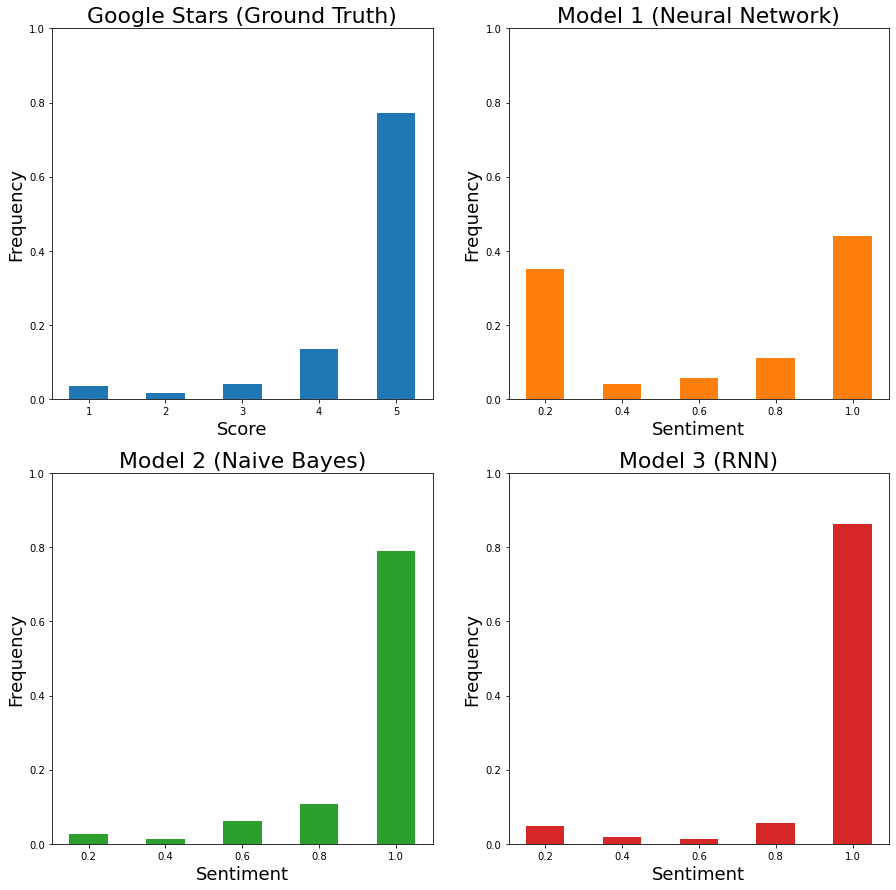

In [11]:
stars = df_spanish['score'].tolist()

hist,bins = np.histogram(stars,np.arange(1,7,1))
dist_normed = np.divide(hist,float(np.sum(hist)))

bincenters1, y1, list_w1 = plot_histo_normalized(sentiment_model1,'model 1','histo_model1_picaron',0.2,0.0,1)
bincenters2, y2, list_w2 = plot_histo_normalized(sentiment_model2,'model 2','histo_model2_picaron',0.2,0.0,1)
bincenters3, y3, list_w3 = plot_histo_normalized(sentiment_model3,'model 3','histo_model2_picaron',0.2,0.0,1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)

ax1.bar(bins[:-1], dist_normed, width=0.5,color='#1f77b4')
ax2.bar(np.array([0.2,0.4,0.6,0.8,1]), y1, width=0.1,color='#ff7f0e')
ax3.bar(np.array([0.2,0.4,0.6,0.8,1]), y2, width=0.1,color='#2ca02c')
ax4.bar(np.array([0.2,0.4,0.6,0.8,1]), y3, width=0.1,color='#d62728')

ax1.set_ylim([0,1])
ax2.set_ylim([0,1])
ax3.set_ylim([0,1])
ax4.set_ylim([0,1])

ax1.set_xlabel('Score',fontsize=18)
ax1.set_ylabel('Frequency',fontsize=18)

ax2.set_xlabel('Sentiment',fontsize=18)
ax2.set_ylabel('Frequency',fontsize=18)
ax3.set_xlabel('Sentiment',fontsize=18)
ax3.set_ylabel('Frequency',fontsize=18)
ax4.set_xlabel('Sentiment',fontsize=18)
ax4.set_ylabel('Frequency',fontsize=18)

ax1.set_title('Google Stars (Ground Truth)',fontsize=22)
ax2.set_title('Model 1 (Neural Network)',fontsize=22)
ax3.set_title('Model 2 (Naive Bayes)',fontsize=22)
ax4.set_title('Model 3 (RNN)',fontsize=22)

In [12]:
sentiment_model1_discretized = discretize_distribution(sentiment_model1)
sentiment_model2_discretized = discretize_distribution(sentiment_model2)
sentiment_model3_discretized = discretize_distribution(sentiment_model3)

---
# Comparing the model performance

## Kolmogorov–Smirnov test [5,6]

In [13]:
scipy.stats.ks_2samp(stars, sentiment_model1_discretized)        

KstestResult(statistic=0.3551219512195122, pvalue=8.86404232743862e-58)

In [14]:
scipy.stats.ks_2samp(stars, sentiment_model2_discretized)

KstestResult(statistic=0.018536585365853658, pvalue=0.9946269250720642)

In [15]:
scipy.stats.ks_2samp(stars, sentiment_model3_discretized)

KstestResult(statistic=0.1073170731707317, pvalue=1.468468744486813e-05)

In [16]:
df_spanish['sentiment_model1_discretized']= sentiment_model1_discretized
df_spanish['sentiment_model2_discretized']= sentiment_model2_discretized
df_spanish['sentiment_model3_discretized']= sentiment_model3_discretized

## More performance metrics

In [32]:
df_compare = pd.DataFrame({'Model1':performance_metrics(df_spanish,1),'Model 2':performance_metrics(df_spanish,2),'Model 3':performance_metrics(df_spanish,3)})
df_compare.index = ['Precision', 'Recall', 'F1 score', 'TNR']
print(df_compare)

           Model1  Model 2  Model 3
Precision    1.00     0.99     1.00
Recall       0.66     1.00     0.94
F1 score     0.80     0.99     0.97
TNR          1.00     0.75     1.00


### Conclusion

The Model 2 (multinomial naive bayes) seems to perform best. The KS test indicates that is the only model in which H0 cannot be rejected. (H0= there are no significant differences between the google stars distribution and the sentiment distribution). 

Moreover, the Model 2 yields the highest F1 score. This result is consistent with different datasets (different restaurants reviews). 

The Model 1 is the one that performed the worst. It shows a marked bias towards the negative sentiment. 

---
## Examples





### Examples of false negatives

False negative in Model 2

In [19]:
df_spanish.query('score==5 and sentiment_model2_discretized<=2').sort_values('sentiment_model2_discretized',ascending=True)['text'].values[1]

'Que decir excelente todo, no se lo pueden perder!!!!!'

### Example of false positive

In [25]:
df_spanish.query('score==1 and sentiment_model2_discretized>=4').sort_values('sentiment_model2_discretized',ascending=False)['text'].values[0]

'Caroooo para tan poco lugar y mala atencion. Buena comida gourmet'

## Conclusion

Above we can see some examples of False negatives and false positives. The language employed seems rather informal. That might be the reason of the wrong performance (the models are not capable of detecting informal language).



---
# **Analytics**


## Who is harder as a reviewer : male or female?



Add gender column to the dataframe

In [22]:
gender = []
for i in range(0,len(df_spanish)):
  name = df_spanish['user_name'].iloc[i]
  gender += [get_gender2(name)]
df_spanish['gender'] = gender

In [42]:
mean_female = df_spanish[df_spanish['gender']=='f']['score'].mean()
std_female = df_spanish[df_spanish['gender']=='f']['score'].std()
mean_male = df_spanish[df_spanish['gender']=='m']['score'].mean()
std_male = df_spanish[df_spanish['gender']=='m']['score'].std()

print("Score\n")
print("Number of females:",len(df_spanish[df_spanish['gender']=='f']['score']))
print("Number of males:",len(df_spanish[df_spanish['gender']=='m']['score']))

print("Female:\n","mean=",round(mean_female,2),"std=",round(std_female,2))
print("Male:\n","mean=",round(mean_male,2),"std=",round(std_male,2))

Score

Number of females: 406
Number of males: 551
Female:
 mean= 4.56 std= 0.98
Male:
 mean= 4.62 std= 0.87


In [44]:
df_spanish['sentiment_model2_discretized'] = sentiment_model2_discretized 
mean_female = df_spanish[df_spanish['gender']=='f']['sentiment_model2_discretized'].mean()
std_female = df_spanish[df_spanish['gender']=='f']['sentiment_model2_discretized'].std()
mean_male = df_spanish[df_spanish['gender']=='m']['sentiment_model2_discretized'].mean()
std_male = df_spanish[df_spanish['gender']=='m']['sentiment_model2_discretized'].std()


print("Sentiment\n")

print("Female:\n","mean=",round(mean_female,2),"std=",round(std_female,2))
print("Male:\n","mean=",round(mean_male,2),"std=",round(std_male,2))

Sentiment

Female:
 mean= 4.6 std= 0.97
Male:
 mean= 4.64 std= 0.79


###Two sample t-test [7]

In [24]:
stats.ttest_ind(df_spanish[df_spanish['gender']=='f']['score'], df_spanish[df_spanish['gender']=='m']['score'])

Ttest_indResult(statistic=-1.006289318708086, pvalue=0.3145313110124029)

## Conclusion

Although the mean values seem to show that females are harder reviewers, the t-student test indicates that there are no significant differences between males and females regarding the way they evaluate restaurants (given de pvalue, the null hipothesis cannot be rejected). 

Note 1: The coclusions above mentioned apply in both the score and the sentiment (with model 2). This is consistent with the fact that model 2 captures the escence of the google score.

Note 2: these result is consistent with other restaurant reviews (not only the one shown here). 

---

# Bibliography

[1]  http://python-apuntes.blogspot.com/2018/11/identificar-genero-de-un-nombre.html

[2]  https://github.com/sentiment-analysis-spanish/sentiment-spanish

[3]  https://github.com/aylliote/senti-py

[4]  https://github.com/pysentimiento/pysentimiento

[5]  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

[6]  https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

[7]   https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/